# Simulated IRT Data Generation
To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature, because these at least have some history/credibility as model data.

In [21]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.clustering
import nirt.irf
import nirt.simulate.simulate_data
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

# Deterministic results.
numpy.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 5
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

In [23]:
X, theta, b, c = nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym=asym, discrimination=discrimination)

(1000, 5)


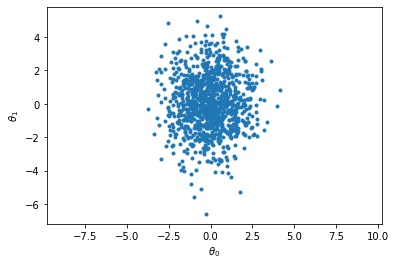

In [24]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta.shape)
plt.plot(theta[:,0], theta[:,1], '.')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.axis('equal')
plt.show()

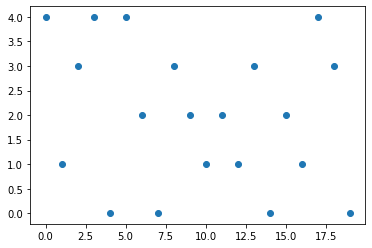

In [25]:
# Plot item classes.
plt.scatter(range(I), c)

# Item Clustering into Classes
We use k-means with abs cosine distance (generally, over the set of persons that answered the two items between which the distance is measured; this only approximately satisfies the triangle inequality, but approximately enough for large $P$) to cluster items into $C$ dimensions.

In [26]:
# Item difficulty proxy = success rate on item
print(X.shape)
print(np.mean(X, axis=0))

(1000, 20)
[0.94  0.881 0.875 0.845 0.773 0.754 0.714 0.638 0.59  0.528 0.469 0.405
 0.365 0.318 0.251 0.209 0.19  0.122 0.1   0.084]


In [27]:
d = nirt.clustering.abs_cos_dist(X)

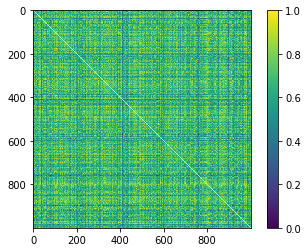

In [28]:
plt.imshow(d)
plt.colorbar()

In [29]:
#kmeans = sklearn.cluster.KMeans(n_clusters=C, random_state=0).fit(X.transpose())
#print(kmeans.labels_)
#print(kmeans.cluster_centers_)
#print(kmeans.n_iter_)
#print(kmeans.inertia_)

Whether using k-means with Euclidean distance, or agglomerative clustering with abs cos distance, it's not easy to recover the $C$ classes from responses, since items that measure the same dimension are not necessarily highly correlated.

For now, we will assume the apriori knownledge of $c$, the correspondence between items and dimensions. 

In [30]:
u, s, vh = svd(X)

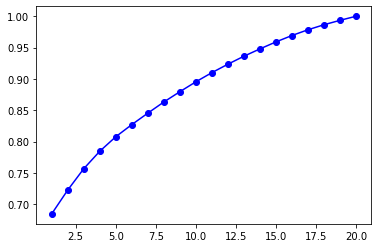

In [31]:
plt.plot(np.arange(1, len(s)+1), np.cumsum(s**2)/(s**2).sum(), 'bo-')

In [32]:
print(vh.shape)
for r in range(1, X.shape[1] + 5, 5):
    P = vh[:r].transpose()
    print(r, (norm(X - (X.dot(P)).dot(P.transpose())) / norm(X)))

r = 5
P = vh[:r].transpose()
t = X.dot(P)
X_reconstructed = t.dot(P.transpose())
XC = X.dot(P)
print(X.shape, P.shape, XC.shape)
# print(P[:3])
# print(t[:4])
# print(X[3:])
# print(X_reconstructed[3:])

(20, 20)
1 0.5614612168141612
6 0.4157615376835695
11 0.29992159798982854
16 0.1752724888983225
21 1.484023873548021e-15
(1000, 20) (20, 5) (1000, 5)


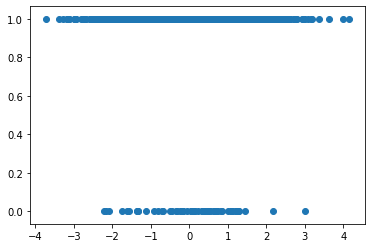

In [33]:
plt.scatter(theta[:,0], X[:,0])

Looks like it is not easy to reconstruct the item classes, since items can be highly correlated just because they are both easy or both difficult; their correlation is not high if and only if they measure the same dimension. Thus, we will assume that the item classification is given (which is true in most use cases, except for behavioral assessment, where items are general questions and are not easily relatable to a single dimension = subject of interest).

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

In [34]:
# Person means for each subscale (dimension): P x C
x_subscale = np.array([np.mean(X[:, np.where(c == d)[0]], axis=1) for d in range(C)]).transpose()
# Population mean and stddev of each subscale.
population_mean = x_subscale.mean(axis=0)
population_std = x_subscale.std(axis=0)
theta_init = (x_subscale - population_mean) / population_std

In [35]:
theta

array([[ 1.63455663, -1.45555377,  2.76869672, -0.64920885,  2.74641934],
       [ 0.74766926,  1.86677934,  0.68069284, -0.23303119,  1.52169263],
       [-1.24033239, -0.64678785,  0.38678675,  0.48372342,  0.03608254],
       ...,
       [ 3.62284625,  2.56976922, -0.04508968,  1.90886886,  0.81205035],
       [-0.30714109,  2.03092209,  1.03349154, -2.70671932,  0.76484915],
       [ 0.31012937, -1.23489292,  0.63599881, -0.68333639,  0.33486327]])

In [36]:
theta_init

array([[ 1.26966007, -0.79743421,  1.73487314, -0.89872552,  0.43260106],
       [ 1.26966007,  0.96485134,  0.92569724, -0.89872552,  0.43260106],
       [-0.75531612, -0.79743421,  0.11652133,  1.13689288,  0.43260106],
       ...,
       [ 2.28214816,  0.96485134,  0.11652133,  1.13689288,  1.70871037],
       [ 0.25717198,  1.84599411,  0.92569724, -0.89872552,  0.43260106],
       [ 0.25717198, -0.79743421, -0.69265458,  0.11908368,  0.43260106]])

In [37]:
# Looks like persons a1 and 2 have similar response patterns but different theta's in subscale
# c=1.
print(X[:2])
print(theta[:2])
print(theta_init[:2])

[[1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0]]
[[ 1.63455663 -1.45555377  2.76869672 -0.64920885  2.74641934]
 [ 0.74766926  1.86677934  0.68069284 -0.23303119  1.52169263]]
[[ 1.26966007 -0.79743421  1.73487314 -0.89872552  0.43260106]
 [ 1.26966007  0.96485134  0.92569724 -0.89872552  0.43260106]]


# Building IRFs from $\theta$
The IRF of item $i$ is a 1D function over the subscale $c(i)$ item $i$ measures.


In [38]:
t = theta_init
print("Initial guess range", np.min(t), np.max(t))
print("Solution range", np.min(theta), np.max(theta))

Initial guess range -3.3957268736062836 2.282148162808574
Solution range -6.606440164426663 5.238647327938029


[       nan        nan        nan        nan        nan        nan
        nan        nan 0.         0.84642857 0.97243108 1.
 1.                nan        nan        nan        nan        nan
        nan        nan]
[ nan  nan  nan  nan  nan  nan  nan  nan 0.   0.86 1.   1.   1.    nan
  nan  nan  nan  nan  nan  nan]


/Users/olivne/miniconda3/envs/irt/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/olivne/miniconda3/envs/irt/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


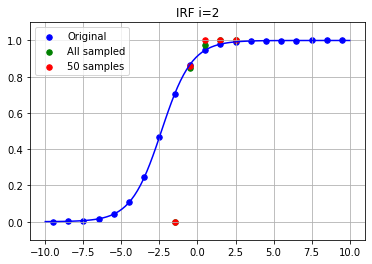

In [39]:
n = 20
s = 50
i = 2 # Item number

bins = nirt.irf.create_bins(t[:, c[i]], n)
irf = nirt.irf.histogram(X[:,i], bins)
sampled_bins = nirt.irf.sample_bins(t[:, c[i]], n, s)
sampled_irf = nirt.irf.histogram(X[:,i], sampled_bins)

ax = plt.gca()
nirt.simulate.simulate_data.plot_model_irf(ax, i, (discrimination, b[i], c[i], asym),  n, color="blue", label="Original")
nirt.simulate.simulate_data.plot_discrete_irf(ax, i, irf,  n, color="green", label="All sampled")
nirt.simulate.simulate_data.plot_discrete_irf(ax, i, sampled_irf,  n, color="red", label="{} samples".format(s))
ax.grid(True)
_ = ax.legend()

print(irf[0]/irf[1])
print(sampled_irf[0]/sampled_irf[1])

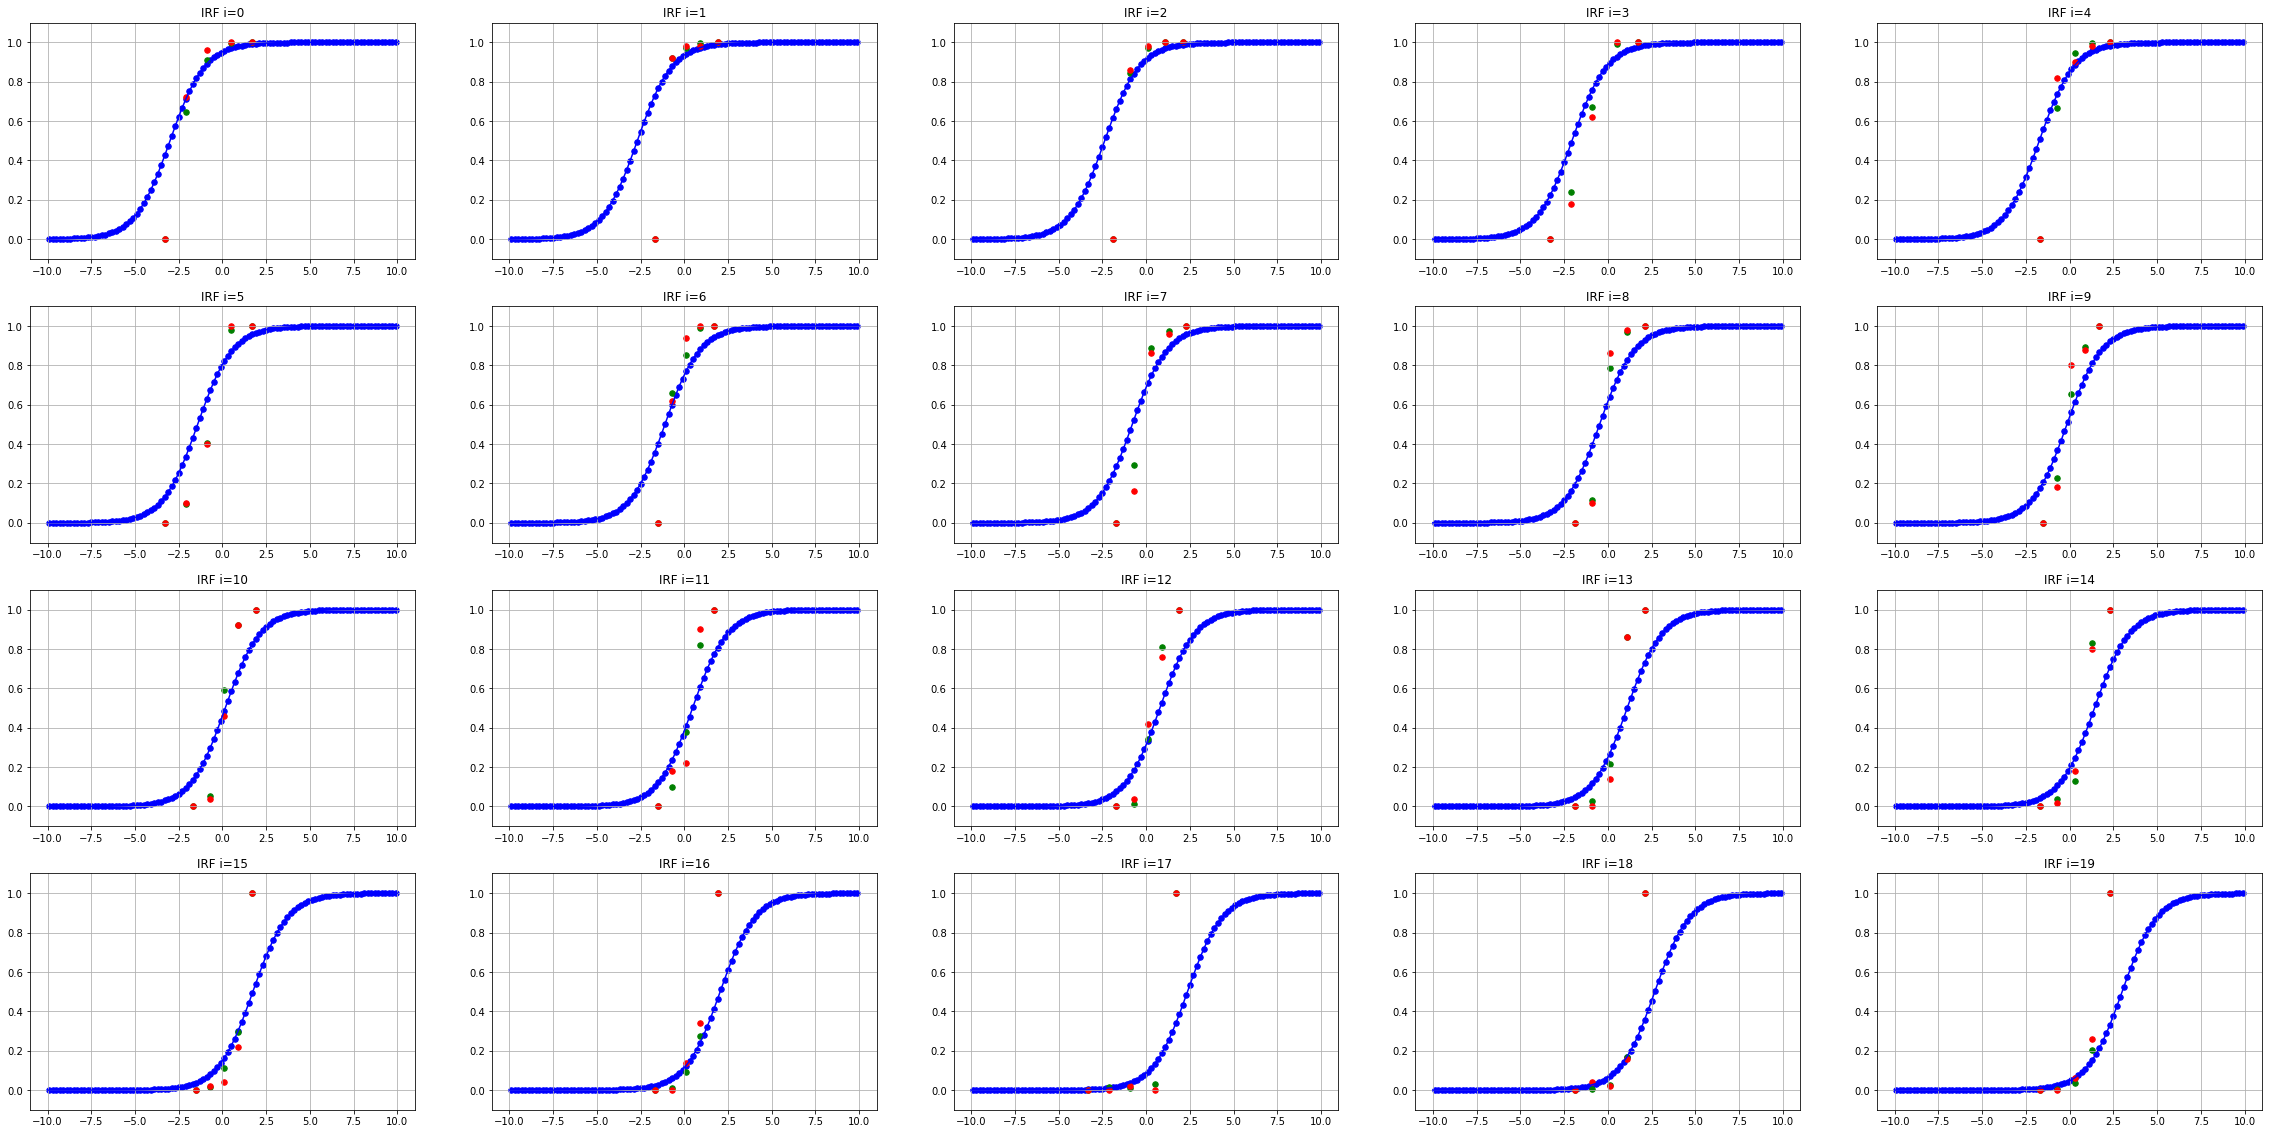

In [40]:
n = 100
s = 50

# Bin and bin-and-sample personsin all dimensions.
bins = [nirt.irf.create_bins(t[:, d], n) for d in range(C)]
sampled_bins = [nirt.irf.sample_bins(t[:, d], n, s) for d in range(C)]

# Plot all item IRFs.

fig, axs = plt.subplots(4, 5, figsize=(40, 20))
for i in range(I):
    irf = nirt.irf.histogram(X[:,i], bins[c[i]])
    sampled_irf = nirt.irf.histogram(X[:,i], sampled_bins[c[i]])

    ax = axs[i // 5, i % 5]
    nirt.simulate.simulate_data.plot_model_irf(ax, i, (discrimination, b[i], c[i], asym),  n, color="blue", label="Original")
    nirt.simulate.simulate_data.plot_discrete_irf(ax, i, irf,  n, color="green", label="All sampled")
    nirt.simulate.simulate_data.plot_discrete_irf(ax, i, sampled_irf,  n, color="red", label="{} samples".format(s))
    ax.grid(True)
    #_ = ax.legend()

# Estimating $\theta$ using MCMC given IRF
The IRF of item $i$ is a 1D function over the subscale $c(i)$ item $i$ measures.
